In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn torch tabulate termcolor


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tabulate import tabulate
from termcolor import colored

# Define stock symbols
stock_symbols = ['F', 'GOOG', 'JPM', 'AMZN', 'TGT']

# Download historical data for each stock symbol
for symbol in stock_symbols:
    stock_data = yf.download(symbol, start="2020-01-01", end="2024-01-01")
    stock_data.to_csv(f"{symbol}.csv")

# Importing the Data
stock_data = {}
for symbol in stock_symbols:
    stock_data[symbol] = pd.read_csv(f"{symbol}.csv", index_col="Date", parse_dates=True)

adj_close = pd.DataFrame()
for symbol in stock_symbols:
    adj_close[symbol] = stock_data[symbol]['Adj Close']

# Check for and handle NaN values
#adj_close.fillna(method='ffill', inplace=True)
#adj_close.dropna(inplace=True)

# Preprocess the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(adj_close)

# Create sequences for transformer input
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 32
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split data into train and test sets
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(seq_length * input_size, input_size)

    def forward(self, src):
        src = self.transformer_encoder(src)
        src = src.view(src.size(0), -1)
        out = self.fc(src)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[2]
num_heads = 1  # Ensure input_size is divisible by num_heads
num_layers = 2
model = TransformerModel(input_size=input_size, num_heads=num_heads, num_layers=num_layers, seq_length=SEQ_LENGTH)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adjusted learning rate

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

# Evaluate the model
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions.append(outputs.numpy())

predictions = np.concatenate(predictions, axis=0)
predictions = scaler.inverse_transform(predictions)

# Cap extreme returns
predictions = np.clip(predictions, adj_close.values.min(), adj_close.values.max())

# Use predictions for portfolio optimization
expected_returns = predictions.mean(axis=0)
cov_matrix = np.cov(predictions, rowvar=False)

# Portfolio optimization using expected returns from transformer
num_portfolios = 2500
num_stocks = len(stock_symbols)

portfolio_weights = []
portfolio_returns = []
portfolio_volatilities = []

np.random.seed(42)

for portfolio in range(num_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    portfolio_weights.append(weights)

    returns = np.dot(weights, expected_returns)
    portfolio_returns.append(returns)

    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    portfolio_volatilities.append(volatility)

portfolios = pd.DataFrame({
    'Returns': portfolio_returns,
    'Volatility': portfolio_volatilities
})

max_return_idx = np.argmax(portfolio_returns)
max_return_portfolio = portfolio_weights[max_return_idx]

# Display the results
table_data = []
table_data.append([colored("Max Return Portfolio", 'blue')])
for symbol, weight in zip(stock_symbols, max_return_portfolio):
    table_data.append([colored(f"{symbol}: {weight *100 :.2f}%", 'blue')])
table_data.append([colored(f"Expected Return: {portfolio_returns[max_return_idx] :.2f}%", 'blue')])
table_data.append([colored(f"Volatility: {portfolio_volatilities[max_return_idx] :.2f}%", 'blue')])

print(tabulate(table_data, tablefmt='plain'))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 0.2774635824561119
Epoch 2/10, Loss: 0.08700550317764283
Epoch 3/10, Loss: 0.06479030355811119
Epoch 4/10, Loss: 0.05611884370446205
Epoch 5/10, Loss: 0.03821656107902527
Epoch 6/10, Loss: 0.027077393755316734
Epoch 7/10, Loss: 0.02135805808007717
Epoch 8/10, Loss: 0.01690305449068546
Epoch 9/10, Loss: 0.015176001489162445
Epoch 10/10, Loss: 0.012687895186245442
Max Return Portfolio
F: 0.53%
GOOG: 7.05%
JPM: 15.29%
AMZN: 14.12%
TGT: 63.01%
Expected Return: 171.72%
Volatility: 18.40%


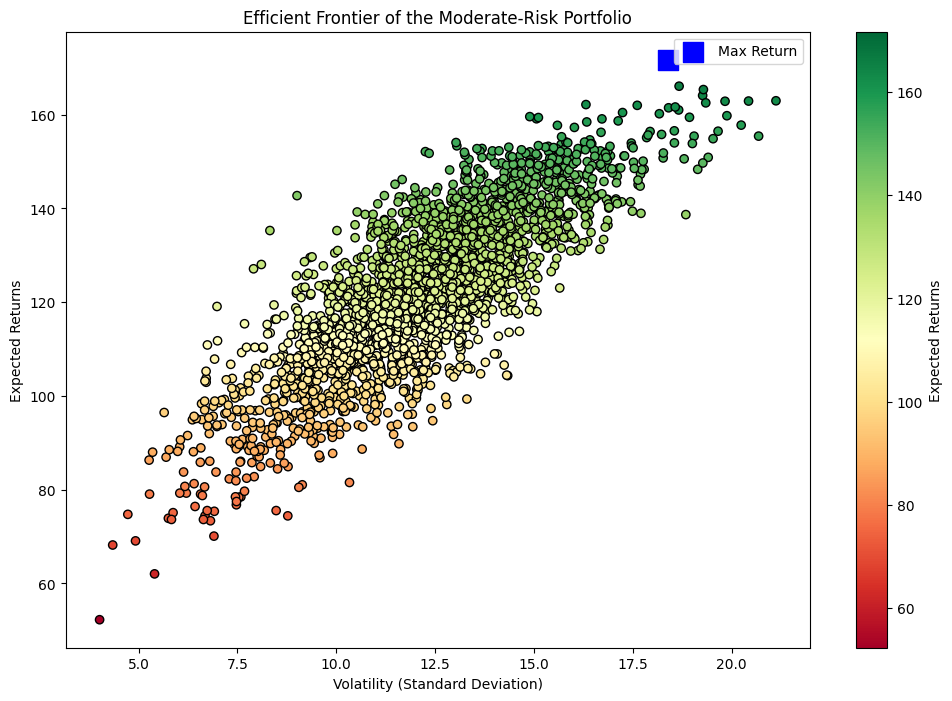

In [23]:
# Plotting the Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=portfolios['Returns'], cmap='RdYlGn', edgecolors='black', marker='o')
plt.colorbar(label='Expected Returns')
plt.scatter(portfolio_volatilities[max_return_idx], portfolio_returns[max_return_idx], c='blue', marker='s', s=200, label='Max Return')
plt.title('Efficient Frontier of the Moderate-Risk Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.legend()
plt.show()